# etape 4 - challenge FTP

## analyse sur Wireshark
Dans cette analyse, nous explorons une capture réseau réalisée à l'aide de Wireshark sur un échange FTP. Le fichier analysé est *ftp-total.pcapng.*  
Pour observer uniquement les échanges FTP, nous appliquons le filtre `tcp.port == 20 || tcp.port == 21`, qui sélectionne les communications liées aux commandes FTP (port 21 du serveur) et au transfert de données (port 20 du serveur), ainsi que les ouvertures et fermetures des sessions TCP.

Le client envoie ses commandes sur le port 21, et le serveur y répond avec des codes standards. Le transfert des données (contenu de répertoires, fichiers) passe par le port 20. À chaque échange (commande ou réponse), un acquittement TCP (ACK) est émis. Il est important de noter que le port utilisé (et sont ouverture) pour les données peut varier en fonction du mode de transfert (actif ou passif).

## Déroulement de la session FTP
### 1. Établissement de la connexion
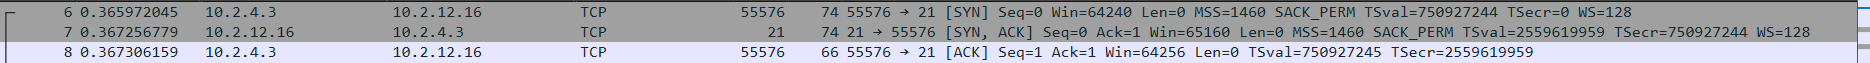  
Une connexion TCP est établie entre le client (10.2.4.3, port 55576) et le serveur (10.2.12.16, port 21). Le processus suit le schéma classique du "3-Way Handshake". Chaque échange est suivi d’un acquittement sec (ACK) sans données.
### 2. Message de bienvenue
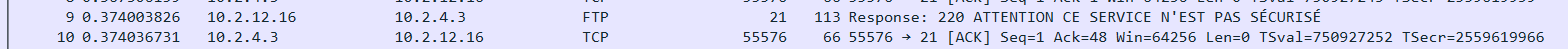  
Le serveur envoie un message d’avertissement concernant **l’absence de sécurité sur la communication**, avec le code 220 ("Service prêt pour un nouvel utilisateur").
### 3. Authentification du client
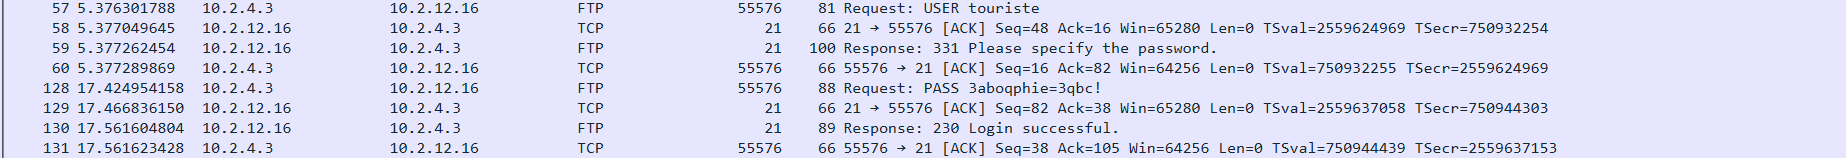  
Le client s’identifie avec le nom d’utilisateur `touriste` et le mot de passe `3aboqphie=3qbc!`. Le serveur accepte l’authentification (code 230 : "Authentification réussie").  
__Attention : Le nom d’utilisateur et le mot de passe sont envoyés en clair !__  
__FTP ne chiffre aucune donnée, aujourd'hui on considère ce protocole comme obsolète et vulnérable.__  
__Il est donc recommandé d’utiliser des alternatives sécurisées telles que FTPS ou SFTP. ou autre.__
### 4. Informations système du serveur
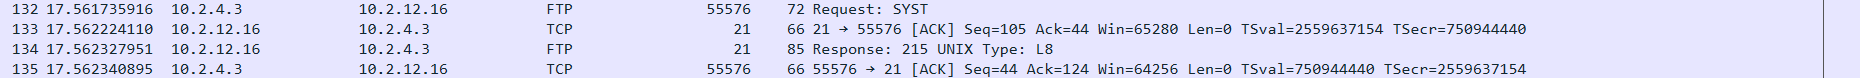  
Le client interroge le serveur via la commande `SYST`. Le serveur répond avec le code 215 ("Type NAME du système") et le message `UNIX Type: L8`, indiquant un système de type UNIX (donc Linux, BSD ou autre, mais pas Windows...) avec un transfert en mode binaire 8 bits ("Local 8-bits").
### 5. Configuration du transfert actif
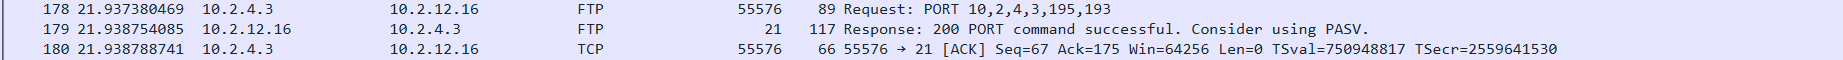  
Le client envoie la commande `PORT 10,2,4,3,195,193`, demandant au serveur d’utiliser une connexion active vers l’adresse 10.2.4.3, port 50113 (195×256 + 193). (le serveur ouvre une connexion vers le client)
### 6. Transfert de la liste de fichiers (`LIST`)
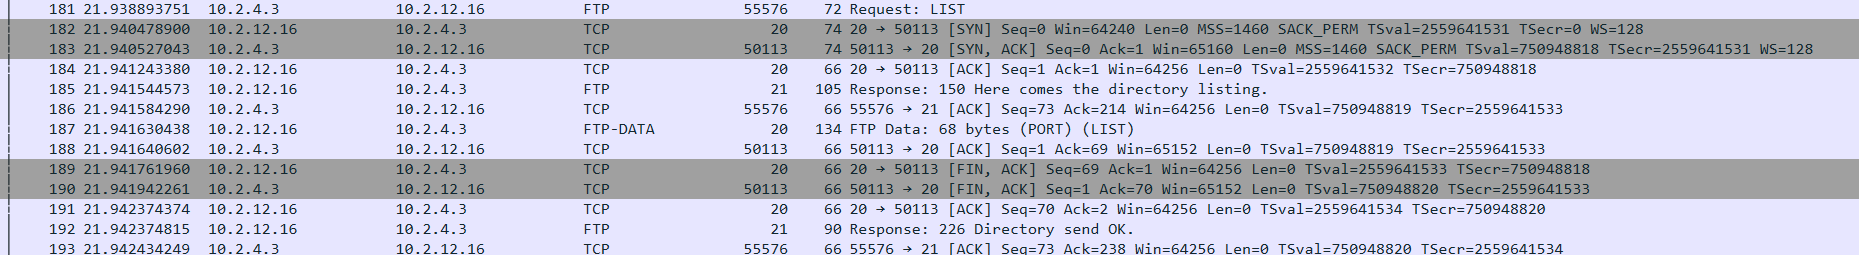  
Le client envoie la commande `LIST`. Le serveur (10.2.12.16) établit une connexion TCP depuis son port 20 vers le port 50113 du client (10.2.4.3), pour transmettre la liste des fichiers du répertoire courant.  
Les données sont envoyées via cette connexion, suivies d’accusés de réception. La connexion est ensuite correctement fermée (échange de FIN, ACK). Le serveur confirme la fin du transfert avec le code 226 ("Directory send, OK").
### 7. Passage en mode binaire (TYPE I)
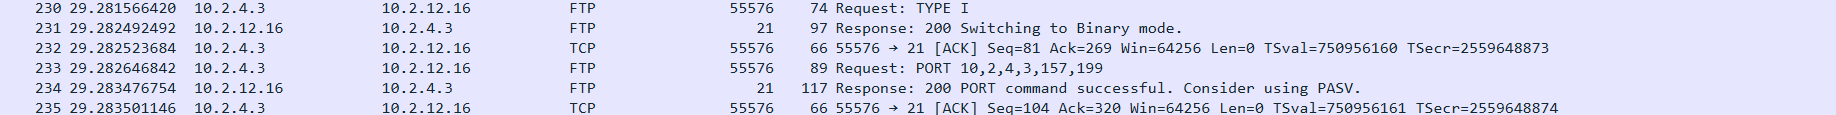  
Le client envoie la commande `TYPE I` pour activer le mode binaire, nécessaire pour les fichiers non-textuels. Le serveur répond avec le code 200 ("OK") et le message "Switching to Binary Mode".  
Ensuite, le client configure une nouvelle connexion (en mode de transfers actif) avec la commande `PORT 10,2,4,3,157,199`, correspondant au port 40331 (=__157__*256+__199__). Le serveur accepte (code 200) et recommande l’utilisation du mode passif (PASV) pour éviter d'eventuelle probleme reseau, notamment avec NAT. ("PORT command successful. Consider using PASV.")
### 8. Téléchargement d’un fichier (RETR)
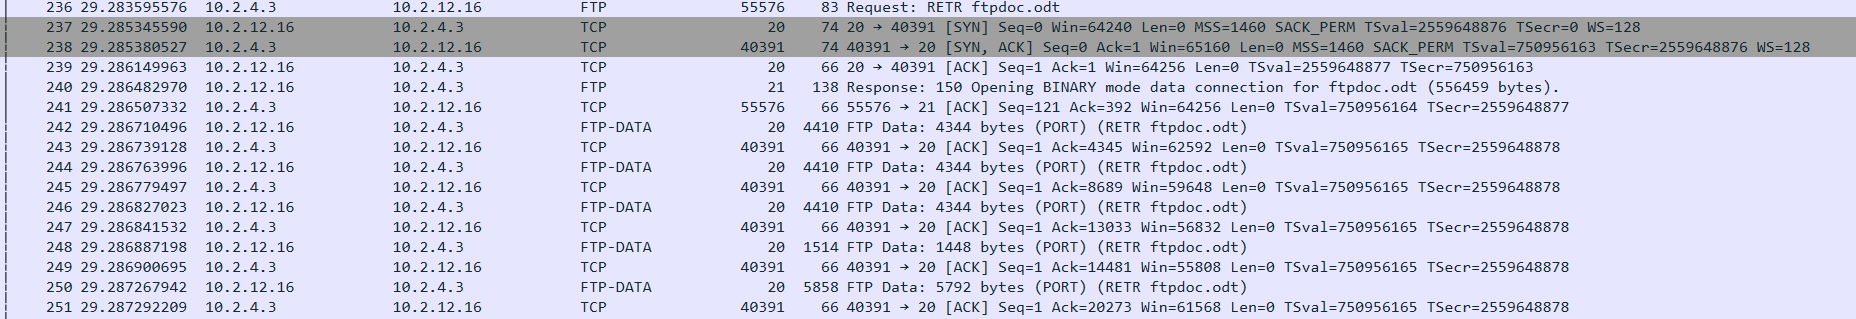  
[...]
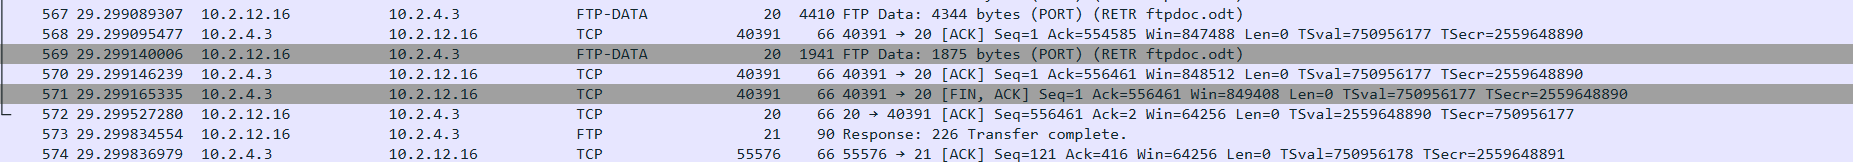  
Le client envoie la commande `RETR ftpdoc.odt` pour télécharger un fichier "ftpdoc.odt". Le serveur répond "Opening BINARY mode data connection for ftpdoc.odt (556459 bytes)" avec le code 150 ("Ouverture de la connexion en cours") et établit une connexion du port 21 du serveur vers le port 40331 du client.  
Le fichier "ftpdoc.odt" (556 459 octets) est envoyé en binaire sur cette connexion. À la fin du transfert, un paquet TCP avec le flag FIN ferme la connexion côté serveur. Le client répond avec un ACK et ferme à son tour. Le serveur confirme la fin avec le code 226 ("Transfer complete.").
### 9. Fermeture de la session
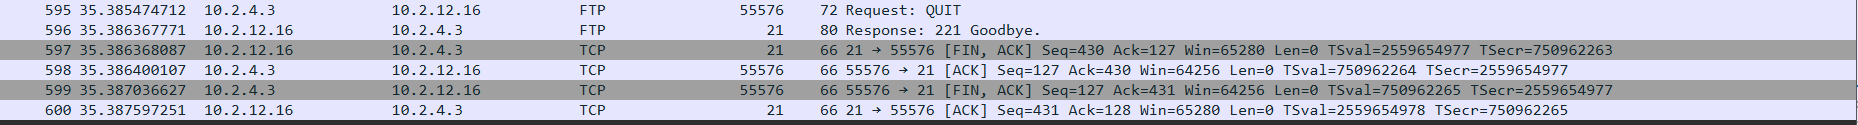  
Le client envoie la commande `QUIT` pour terminer la session FTP. Le serveur répond avec le code 221 ("Goodbye."). Une séquence d’échange FIN/ACK permet de fermer proprement la connexion TCP.

## Extration du fichier ftpdoc.odt
Nous allons récupérer le fichier transféré lors de la session FTP observée dans la capture réseau, à l’aide de Wireshark.

### Explication
Wireshark propose une fonctionnalité permettant de « suivre » un échange TCP. Cela permet d’obtenir l’ensemble du contenu échangé entre le client et le serveur, présenté sous forme de « conversation ».   
Par exemple, pour la session TCP correspondant aux commandes FTP : (10.2.12.16:21 <=> 10.2.4.3:55576)  
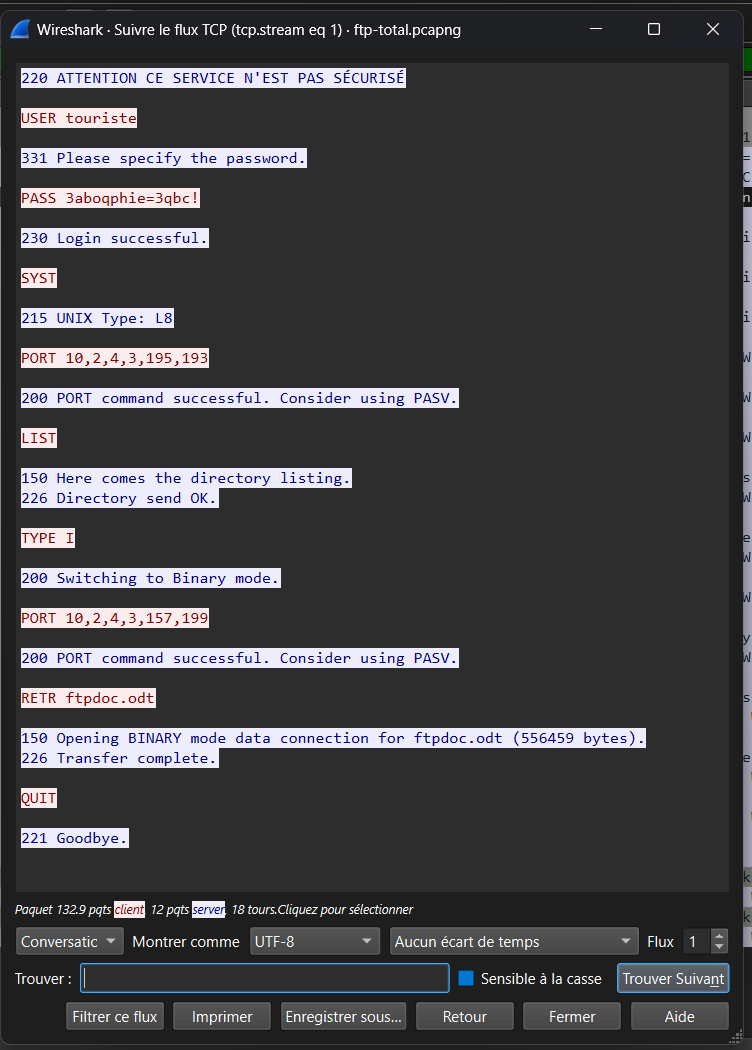  
Grâce à cette fonctionnalité, on peut extraire facilement tout l’échange effectué durant une session TCP.  
### Extraction
Le contenu binaire du fichier que nous voulons extraire correspond à celui de la session TCP dédiée au transfert de données (port de données 20 côté serveur).  
Il suffit donc de « suivre » ce flux TCP :  
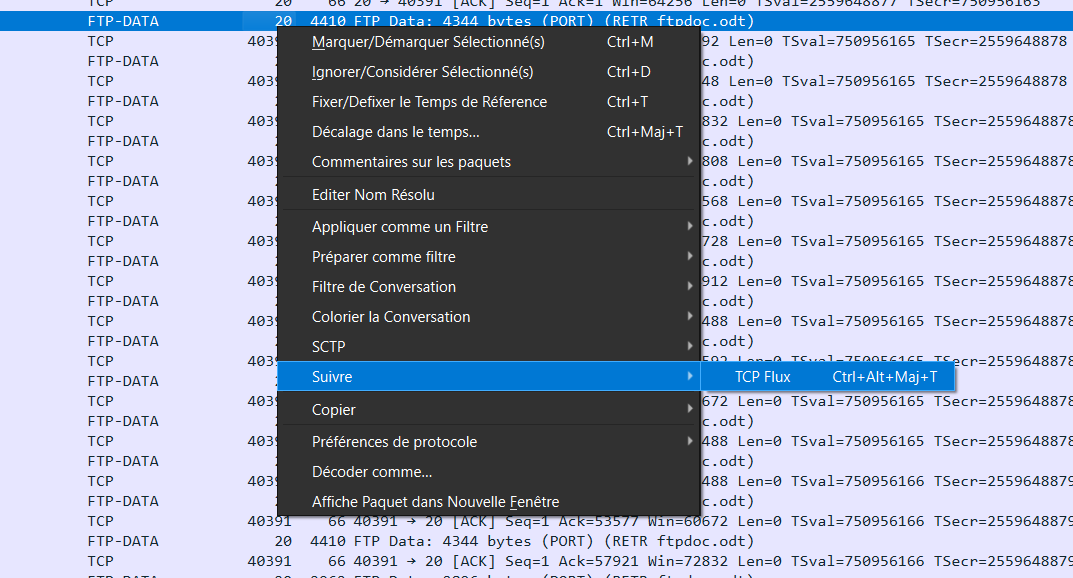  

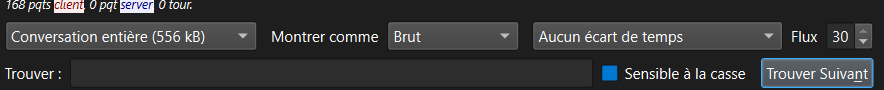  
__Il est essentiel d’afficher le contenu en mode « Brut » afin d’obtenir le flux binaire exact, sans décodage en ASCII, UTF-8 ou autre format texte.__  
Ensuite, il faut cliquez sur « Enregistrer sous » et nommez le fichier "ftpdoc.odt" (attention à respecter l’extension correcte du fichier).  
![Capture d'écran 2025-05-01 161508.png](<attachment:Capture d'écran 2025-05-01 161508.png>)  

Nous obtenons alors le fichier correctement extrait :  
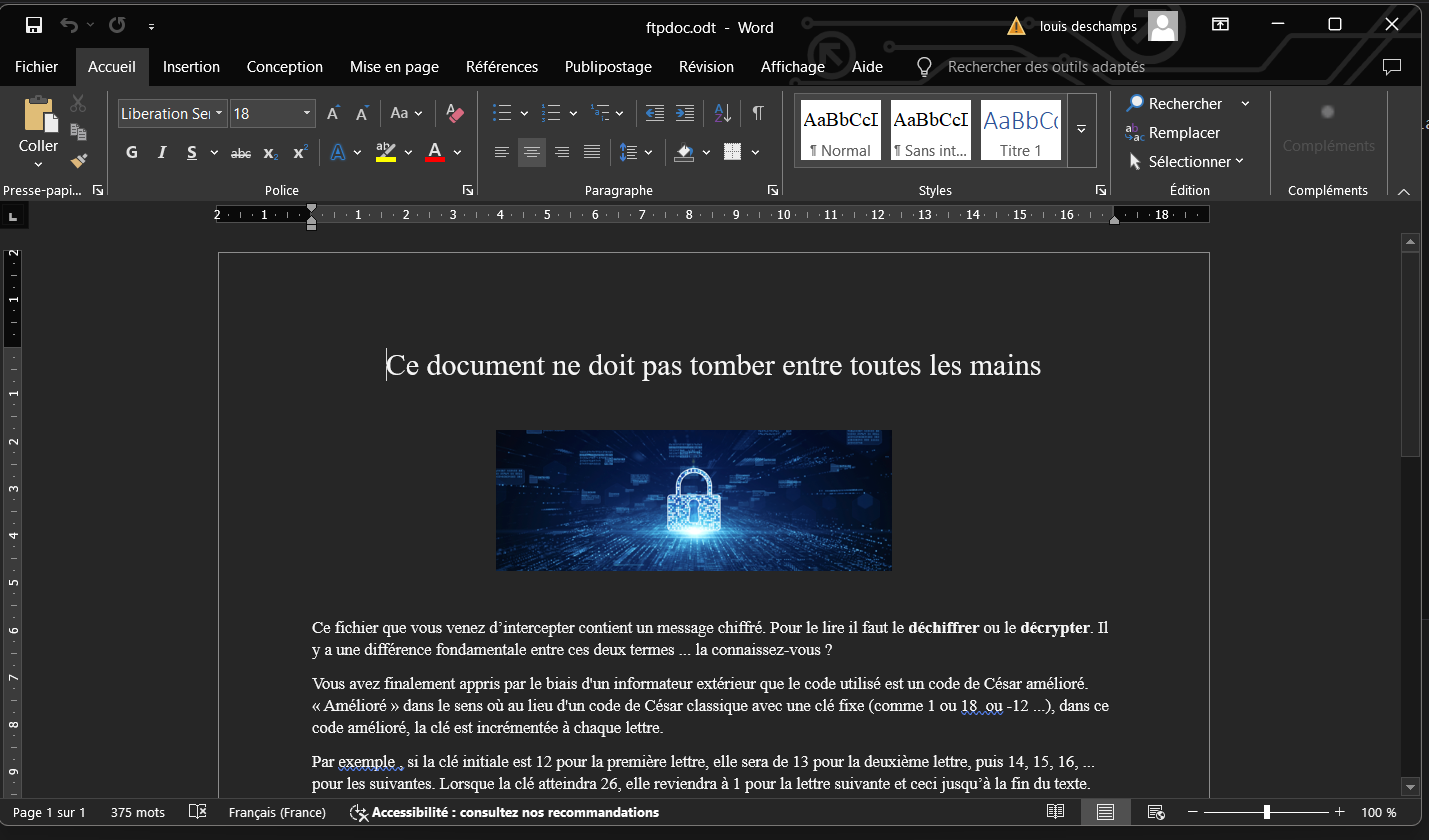

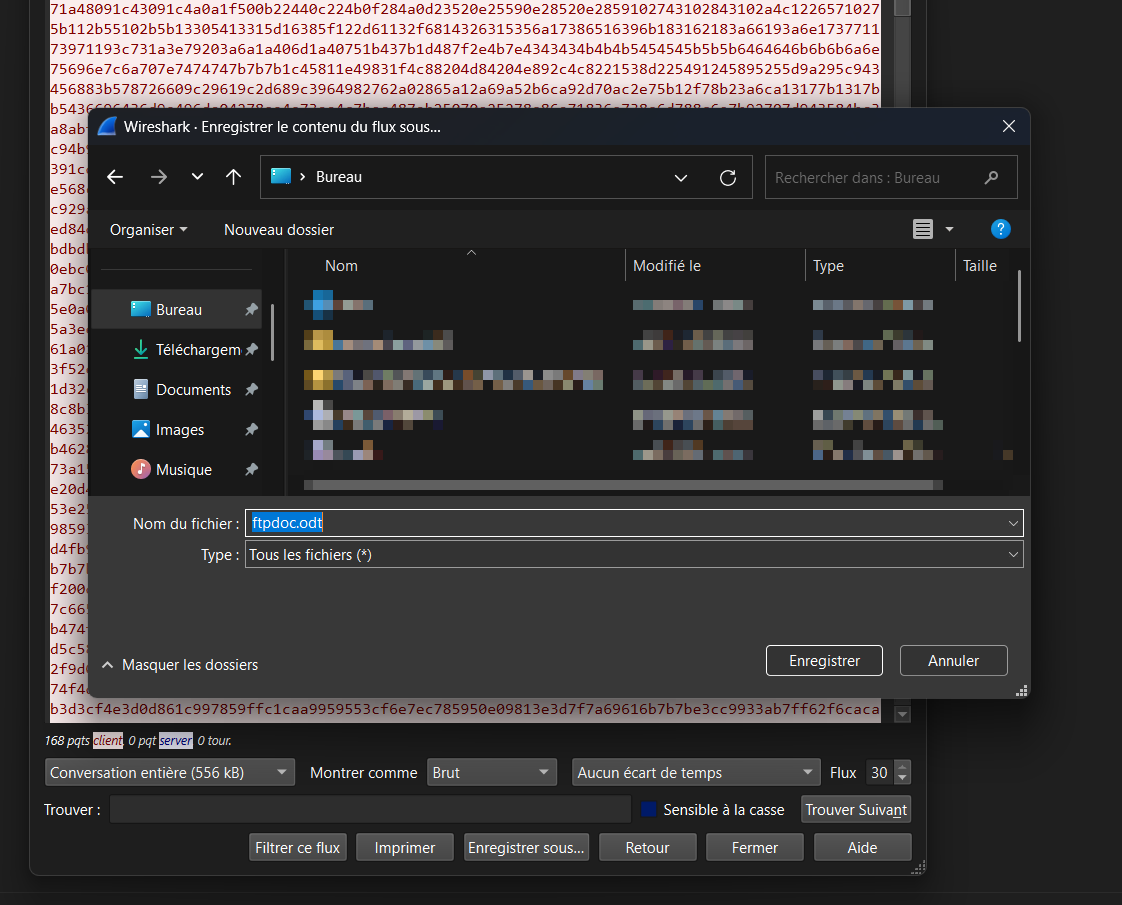

# Automatisation de l'extraction via Python

In [1]:
from scapy.all import *

# Variable globale pour les transferts de fichiers.
ftp_data_port = 0
ftp_data_filename = ""
ftp_data_buffer = bytearray()

def extractcontrol(data):
    global ftp_data_filename, ftp_data_port
    # Pour les identifiants, il faut trouver les commandes avec "USER <utilisateur>" ou "PASS <mot de passe>". On pourrait faire cela avec une simple condition (exemple -> if "USER" in data:)
    # Mais on pourrait aussi sélectionner par erreur d'autres commandes contenant "user" ou "pass" (par exemple, on pourrait avoir "RETR userdata.txt")
    data = data.split(" ",1) # DONC on extrait uniquement la commande et on extrait uniquement le (ou les) argument(s).
    # Le 1 en argument permet de faire un seul découpage. Cela est utile car on pourrait avoir un mot de passe, un nom d'utilisateur ou un fichier avec des espaces, ce qui serait problématique.  
    cmd = data[0] # La commande
    if len(data) == 2: # S'il y a un argument, il y aura deux index dans la table.
        arg = data[1] # L'argument
    else:
        arg = ""
    # Enfin, on peut récupérer les informations voulues :
    if cmd == "USER":
        print(f"Le nom d'utilisateur est : {arg}")
    elif cmd == "PASS":
        print(f"Le mot de passe est : {arg}")
    elif cmd == "PORT": # Le port pour le mode de transfert actif
        arg=arg.split(",")
        ftp_data_port = int(arg[4]) * 256 + int(arg[5])
        print(f"Le client initie une connexion active sur le port {ftp_data_port}")
    elif cmd == "RETR":
        print(f"Le client télécharge le fichier {arg}")
        ftp_data_filename = arg
    elif cmd == "STOR":
        print(f"Le client envoie le fichier {arg}")
        ftp_data_filename = arg

def otherdatapacket(trame):
    global ftp_data_filename, ftp_data_port, ftp_data_buffer
    if ftp_data_port == 0 or ftp_data_filename == "":
        return # S'il n'y a pas de port ouvert ou pas de transfert en cours (les variables ont les valeurs par défaut), la fonction est stoppée immédiatement.
    if trame[TCP].sport == ftp_data_port or trame[TCP].dport == ftp_data_port: # S'il y a un flux TCP avec le port concerné, cela concerne le transfert de fichier.
        if trame.haslayer(Raw): # S'il y a de la donnée
            ftp_data_buffer += trame[Raw].load # Alors on la stocke dans un buffer incrémentiel.
        if 'F' in trame[TCP].flags:  # Le datagramme a un flag FIN alors on enregistre le fichier
            os.makedirs("extracted_files", exist_ok=True) # On crée un dossier s'il n'existe pas.
            path = "extracted_files/"+ftp_data_filename
            with open(path, "wb") as f: # On ouvre un fichier en mode écriture binaire.
                f.write(ftp_data_buffer)
                f.close() # On sauvegarde
            print(f"Fichier sauvegardé : {path}")
            ftp_data_port = 0 # On remet aux valeurs par défaut nos variables globales.
            ftp_data_filename = ""
            ftp_data_buffer = bytearray()

def findFTPpacket(trame): # On cherche si le paquet est bien pour le FTP
    if trame.haslayer(TCP): # Si la trame a la couche TCP, on sait immédiatement que les couches de la trame sont Ether/IP(v6)/TCP et pas autre chose (UDP, ICMP, ARP, STP, etc.)
        if trame[TCP].dport == 21: # On vérifie si le datagramme TCP a comme port de destination 21, donc si le paquet est à destination d'un serveur FTP sur son port de commande.
            if trame.haslayer(Raw): # On cherche si le datagramme contient de la donnée, on cherche donc s'il y a la couche "Raw" (cela correspond à la couche applicative, ici FTP). On exclut donc tous les datagrammes sans données, par exemple les acquittements secs ou les débuts et fins de connexion.
                data = trame[Raw].load.decode('utf-8', errors='ignore') # On récupère le champ "load" qui contient les commandes FTP et on utilise la fonction .decode() pour décoder la suite binaire en chaîne de caractères au format UTF-8 
                data = data.strip() # La fonction .strip() permet de retirer les caractères invisibles tels que les retours chariot "\r" et sauts de ligne "\n"
                #print(data) # Nous avons donc une chaîne qui correspond à la commande envoyée du client FTP au serveur
                extractcontrol(data) # On appelle la fonction pour extraire les données
        otherdatapacket(trame) # Si c'est un datagramme TCP qui n'est pas de commande FTP, alors ça pourrait éventuellement être un transfert. On appelle la fonction qui s'occupe de l'extraction des fichiers.

# Lecture du fichier et boucle principale
for trame in rdpcap("Capture/ftp-total.pcapng"):
    findFTPpacket(trame)

# Pour capture les session ftp en temps reel
#sniff(filter="tcp", prn=findFTPpacket)

Le nom d'utilisateur est : touriste
Le mot de passe est : 3aboqphie=3qbc!
Le client initie une connexion active sur le port 50113
Le client initie une connexion active sur le port 40391
Le client télécharge le fichier ftpdoc.odt
Fichier sauvegardé : extracted_files/ftpdoc.odt


Ce script ci-dessus permet de lire toutes les trames réseau (d'un fichier ou en temps reel) et d'extraire les identifiants et mots de passe d'une session FTP non sécurisée.  
Il permet également d'exfiltrer les fichiers transférés.  
Limitations :  
- Il peut extraire les fichiers UNIQUEMENT si un seul transfert est effectué à la fois. En cas de transferts simultanés, il ne pourra pas récupérer tous les fichiers et cela risque d'entraîner une corruption des fichiers sauvegardés.  
- Il ne fonctionne qu'avec les transferts effectués en mode ACTIF. Le mode PASSIF n'est pas pris en charge.  
- Le contenu binaire des fichiers est stocké en mémoire vive (RAM) avant d'être sauvegardé. Si un fichier transféré dépasse plusieurs gigaoctets, cela peut saturer la mémoire vive de la machine.  

# Bonus : dechiffrage

In [ ]:
encrypted_message="""
COPIER/COLLER LE MESSAGE ICI
"""
def decrypt(encrypted_message, key):
    message = ""
    for char in encrypted_message:
        if char.isalpha():  # Le caractère est-il alphabétique (A-Z, a-z) ?
            char = char.upper()  # On le force en majuscule au cas où.
            # On prend la valeur ASCII de notre caractère, on retire 65 (valeur ASCII de "A"), on obtient la position de la lettre dans l'alphabet.
            # On soustrait la clé, et on récupère le reste de la division euclidienne de 26 (il y a 26 lettres dans l'alphabet, si on dépasse la lettre numéro 26, on repart à 0).
            shifted = (ord(char) - 65 - key) % 26
            message += chr(65 + shifted)  # On convertit le numéro de la lettre en caractère et on le concatène avec la chaîne message.
            key += 1  # On incrémente la clé à chaque itération.
        else:
            message += char
    return message

## Pour tester toutes les combinaisons possibles
# for key in range(1, 27, 1):
#     print(decrypt(encrypted_message, key))

print(decrypt(encrypted_message, 8))
